## 0802 pickle 만들기
    * 0726_DB
    * 카테고리 : 스포츠모빌리티(catelist[6])
        - 전체 758개
    * 앵콜 in text : 1, else 0
        - label 1 비율 약 15%
    * mecab('NNG','MAG','VV','NNP','NNB','VA','VCP','VCN','MAC','MAJ','SF','VV+EC','VV+EP','EP','XR','VV+ETM')
    * 불용어(아 휴 아이구 아이쿠 아이고 등...) 제거 후 COPUS 생성
    * TfidfVectorizer (빈도 순 1000개 단어만)
    * Shufflesplit 사용(train_Test_split 대신.. 왜냐 index 번호를 알고 싶어서)
    * LSTM
        - 3차원데이터 넣어주기
        - 정해님 방법(tokenize)랑 달라서 model.accuracy 안됨
        - pred 예측값을 0,1로 직접 변환(>0.5) 후 y_test와 직접 비교
    * 예측값 상위 게시글 찾아주기(0.95 이상 또는 0.05 이하)
        - 0.95 이상 3개, 0.05 이하 3개의 index를 찾는다
        - 해당되는 index를 가지는 df 행을 가져오고 label 확인

In [5]:
import requests
from bs4 import BeautifulSoup as bsp
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sqlite3

In [6]:
# PYTHON으로 SQLITE3의 DB에 데이터 담기
dbname='20210726_newDB.db'
def insData(d, tblname='wadiznew'):
    with sqlite3.connect(dbname) as conn:
        cur=conn.cursor()
        sql='select * from '+tblname+' where ncategory="'+d+'"'
        ckkey=cur.execute(sql).fetchall()
        if ckkey:
            return ckkey

In [7]:
# df 뽑아내는 함수
def category(i):
    cate=['테크·가전', '패션·잡화', '뷰티', '푸드', '홈리빙', '여행·레저', '스포츠·모빌리티', '공연·컬쳐', 
          '베이비·키즈', '반려동물', '게임·취미', '클래스', '출판', '디자인소품', '소셜·캠페인', '기부·후원', '모임']
    data=insData(cate[i])
    df=pd.DataFrame(data)
    names=['idx','category','name','title','content','supporter','amount','percent','fund','start','end','numofpics','community','key']
    df.columns=names
    encore = "앵콜"
    df['label'] = 0

    for i, title in enumerate(df['title']):
        if title.find(encore) > 0:
            df['label'].iloc[i] = 1
    return df

# 스포츠모빌리티 선택(6)
df=category(6)
print('data는 ', len(df), '개')

data는  758 개


C:\Users\pc\anaconda3\envs\py37\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [8]:
df.head(3)

,idx,category,name,title,content,supporter,amount,percent,fund,start,end,numofpics,community,key,label
0,14992,스포츠·모빌리티,시안인터내셔널,기능성수건과 면수건의 장점을 모두 합쳤다! 신개념 휴대용 수건 트래부스트,"\n 여름 휴가 계획하시나요? 수건먼저 챙겨야죠! 기능성수건의 건조능력과, 면...",824,"41,185,700",8237,"500,000원",2021-06-29,2021-07-19,89,11,https://www.wadiz.kr/web/campaign/detail/112053,0
1,14993,스포츠·모빌리티,휴브릿,고생하는 내차에도 보약한첩!! 내차에도 자연에도 가격또한 착한 엔진보호탕,"\n 비싼 돈 주고 다른 연료 첨가제 쓰고 써봐도 별 차이도, 체감도 안 되신...",134,"3,231,200",323,"1,000,000원",2021-06-29,2021-07-08,37,7,https://www.wadiz.kr/web/campaign/detail/107804,0
2,14994,스포츠·모빌리티,와글리,"[1억8천앵콜]힘들게 테이핑 말고, 발목압박 테이핑양말&종아리압박 슬리브",\n 모든 스포츠게임의 승패는 아주 미세한 부분에서 승패가 갈리곤 합니다. [...,"1,237","39,262,900",7852,"500,000원",2021-06-08,2021-07-06,147,66,https://www.wadiz.kr/web/campaign/detail/109697,1


In [9]:
df.to_csv('sports_0802.csv',mode='w')

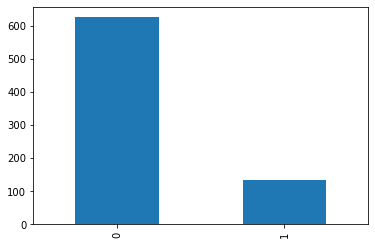

In [10]:
# tdf['title'] - 타이틀+컨텐츠
tdf = df.copy()
tdf['text'] = tdf['title'] + tdf['content']
tdf.head(3)

# label 비율 확인
label=tdf['label']
label.value_counts().plot(kind = 'bar')

label=np.array(label)

In [11]:
!pip install konlpy

In [12]:
!pip install --upgrade pip

In [13]:
!pip install JPype1-1.1.2-cp38-cp38-win_amd64.whl

ERROR: JPype1-1.1.2-cp38-cp38-win_amd64.whl is not a supported wheel on this platform.


In [14]:
!pip install eunjeon

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.text import Tokenizer
from eunjeon import Mecab

def tknWord(txt,cntlimit=1):
    tagger=Mecab()
    kpos=tagger.pos(txt)
    cate=['NNG','MAG','VV','NNP','NNB','VA','VCP','VCN','MAC','MAJ','SF','VV+EC','VV+EP','EP','XR','VV+ETM']
    tkn=[]
    #print(kpos)
    for k in kpos:
        if(k[1] in cate):
            if(len(k[0])>cntlimit):
                tkn.append(k[0])
    return tkn

In [16]:
# 불용어 list
stopwordsstr = '아 휴 아이구 아이쿠 아이고 어 나 우리 저희 따라 의해 을 를 에 의 가 으로 로 에게 뿐이다 의거하여 근거하여 입각하여 기준으로 예하면 예를 들면 예를 들자면 저 소인 소생 저희 지말고 하지마 하지마라 다른 물론 또한 그리고 비길수 없다 해서는 안된다 뿐만 아니라 만이 아니다 만은 아니다 막론하고 관계없이 그치지 않다 그러나 그런데 하지만 든간에 논하지 않다 따지지 않다 설사 비록 더라도 아니면 만 못하다 하는 편이 낫다 불문하고 향하여 향해서 향하다 쪽으로 틈타 이용하여 타다 오르다 제외하고 이 외에 이 밖에 하여야 비로소 한다면 몰라도 외에도 이곳 여기 부터 기점으로 따라서 할 생각이다 하려고하다 이리하여 그리하여 그렇게 함으로써 하지만 일때 할때 앞에서 중에서 보는데서 으로써 로써 까지 해야한다 일것이다 반드시 할줄알다 할수있다 할수있어 임에 틀림없다 한다면 등 등등 제 겨우 단지 다만 할뿐 딩동 댕그 대해서 대하여 대하면 훨씬 얼마나 얼마만큼 얼마큼 남짓 여 얼마간 약간 다소 좀 조금 다수 몇 얼마 지만 하물며 또한 그러나 그렇지만 하지만 이외에도 대해 말하자면 뿐이다 다음에 반대로 반대로 말하자면 이와 반대로 바꾸어서 말하면 바꾸어서 한다면 만약 그렇지않으면 까악 툭 딱 삐걱거리다 보드득 비걱거리다 꽈당 응당 해야한다 에 가서 각 각각 여러분 각종 각자 제각기 하도록하다 와 과 그러므로 그래서 고로 한 까닭에 하기 때문에 거니와 이지만 대하여 관하여 관한 과연 실로 아니나다를가 생각한대로 진짜로 한적이있다 하곤하였다 하 하하 허허 아하 거바 와 오 왜 어째서 무엇때문에 어찌 하겠는가 무슨 어디 어느곳 더군다나 하물며 더욱이는 어느때 언제 야 이봐 어이 여보시오 흐흐 흥 휴 헉헉 헐떡헐떡 영차 여차 어기여차 끙끙 아야 앗 아야 콸콸 졸졸 좍좍 뚝뚝 주룩주룩 솨 우르르 그래도 또 그리고 바꾸어말하면 바꾸어말하자면 혹은 혹시 답다 및 그에 따르는 때가 되어 즉 지든지 설령 가령 하더라도 할지라도 일지라도 지든지 몇 거의 하마터면 인젠 이젠 된바에야 된이상 만큼 어찌됏든 그위에 게다가 점에서 보아 비추어 보아 고려하면 하게될것이다 일것이다 비교적 좀 보다더 비하면 시키다 하게하다 할만하다 의해서 연이서 이어서 잇따라 뒤따라 뒤이어 결국 의지하여 기대여 통하여 자마자 더욱더 불구하고 얼마든지 마음대로 주저하지 않고 곧 즉시 바로 당장 하자마자 밖에 안된다 하면된다 그래 그렇지 요컨대 다시 말하자면 바꿔 말하면 즉 구체적으로 말하자면 시작하여 시초에 이상 허 헉 허걱 바와같이 해도좋다 해도된다 게다가 더구나 하물며 와르르 팍 퍽 펄렁 동안 이래 하고있었다 이었다 에서 로부터 까지 예하면 했어요 해요 함께 같이 더불어 마저 마저도 양자 모두 습니다 가까스로 하려고하다 즈음하여 다른 다른 방면으로 해봐요 습니까 했어요 말할것도 없고 무릎쓰고 개의치않고 하는것만 못하다 하는것이 낫다 매 매번 들 모 어느것 어느 로써 갖고말하자면 어디 어느쪽 어느것 어느해 어느 년도 라 해도 언젠가 어떤것 어느것 저기 저쪽 저것 그때 그럼 그러면 요만한걸 그래 그때 저것만큼 그저 이르기까지 할 줄 안다 할 힘이 있다 너 너희 당신 어찌 설마 차라리 할지언정 할지라도 할망정 할지언정 구토하다 게우다 토하다 메쓰겁다 옆사람 퉤 쳇 의거하여 근거하여 의해 따라 힘입어 그 다음 버금 두번째로 기타 첫번째로 나머지는 그중에서 견지에서 형식으로 쓰여 입장에서 위해서 단지 의해되다 하도록시키다 뿐만아니라 반대로 전후 전자 앞의것 잠시 잠깐 하면서 그렇지만 다음에 그러한즉 그런즉 남들 아무거나 어찌하든지 같다 비슷하다 예컨대 이럴정도로 어떻게 만약 만일 위에서 서술한바와같이 인 듯하다 하지 않는다면 만약에 무엇 무슨 어느 어떤 아래윗 조차 한데 그럼에도 불구하고 여전히 심지어 까지도 조차도 하지 않도록 않기 위하여 때 시각 무렵 시간 동안 어때 어떠한 하여금 네 예 우선 누구 누가 알겠는가 아무도 줄은모른다 줄은 몰랏다 하는 김에 겸사겸사 하는바 그런 까닭에 한 이유는 그러니 그러니까 때문에 그 너희 그들 너희들 타인 것 것들 너 위하여 공동으로 동시에 하기 위하여 어찌하여 무엇때문에 붕붕 윙윙 나 우리 엉엉 휘익 윙윙 오호 아하 어쨋든 만 못하다 하기보다는 차라리 하는 편이 낫다 흐흐 놀라다 상대적으로 말하자면 마치 아니라면 쉿 그렇지 않으면 그렇지 않다면 안 그러면 아니었다면 하든지 아니면 이라면 좋아 알았어 하는것도 그만이다 어쩔수 없다 하나 일 일반적으로 일단 한켠으로는 오자마자 이렇게되면 이와같다면 전부 한마디 한항목 근거로 하기에 아울러 하지 않도록 않기 위해서 이르기까지 이 되다 로 인하여 까닭으로 이유만으로 이로 인하여 그래서 이 때문에 그러므로 그런 까닭에 알 수 있다 결론을 낼 수 있다 으로 인하여 있다 어떤것 관계가 있다 관련이 있다 연관되다 어떤것들 에 대해 이리하여 그리하여 여부 하기보다는 하느니 하면 할수록 운운 이러이러하다 하구나 하도다 다시말하면 다음으로 에 있다 에 달려 있다 우리 우리들 오히려 하기는한데 어떻게 어떻해 어찌됏어 어때 어째서 본대로 자 이 이쪽 여기 이것 이번 이렇게말하자면 이런 이러한 이와 같은 요만큼 요만한 것 얼마 안 되는 것 이만큼 이 정도의 이렇게 많은 것 이와 같다 이때 이렇구나 것과 같이 끼익 삐걱 따위 와 같은 사람들 부류의 사람들 왜냐하면 중의하나 오직 오로지 에 한하다 하기만 하면 도착하다 까지 미치다 도달하다 정도에 이르다 할 지경이다 결과에 이르다 관해서는 여러분 하고 있다 한 후 혼자 자기 자기집 자신 우에 종합한것과같이 총적으로 보면 총적으로 말하면 총적으로 대로 하다 으로서 참 그만이다 할 따름이다 쿵 탕탕 쾅쾅 둥둥 봐 봐라 아이야 아니 와아 응 아이 참나 년 월 일 령 영 일 이 삼 사 오 육 륙 칠 팔 구 이천육 이천칠 이천팔 이천구 하나 둘 셋 넷 다섯 여섯 일곱 여덟 아홉 령 영 이 있 하 것 들 그 되 수 이 보 않 없 나 사람 주 아니 등 같 우리 때 년 가 한 지 대하 오 말 일 그렇 위하 때문 그것 두 말하 알 그러나 받 못하 일 그런 또 문제 더 사회 많 그리고 좋 크 따르 중 나오 가지 씨 시키 만들 지금 생각하 그러 속 하나 집 살 모르 적 월 데 자신 안 어떤 내 내 경우 명 생각 시간 그녀 다시 이런 앞 보이 번 나 다른 어떻 여자 개 전 들 사실 이렇 점 싶 말 정도 좀 원 잘 통하 놓'
stopwords = stopwordsstr.split()

# x_train에서 불용어 제거
x_prep = []
for sentence in tdf['text']:
    temp_X = tknWord(sentence)
    temp_X_tr_stop = [word for word in temp_X if not word in stopwords] 
    x_prep.append(temp_X_tr_stop)

corpus=[' '.join(r) for r in x_prep]

In [23]:
corpus

['기능 수건 수건 장점 합쳤 개념 휴대 수건 트래 부스트 여름 휴가 계획 수건 먼저 기능 수건 건조 능력 수건 합쳤 트래 부스트 장점 합친 개념 휴대 수건 등장 여행 캠핑 중요 제작자 제일 여행 매우 여행 이미 인기 여행 수건 구매 구매 휴대 수건 스페인 해변 와인 축제 토마티나 축제 비자 파티 가져갔 기능 수건 사용 불편 느꼈 금방 보풀 고무 딱딱 냄새 물기 제대로 닦이 불편 불편 직접 수건 오랫동안 연구 끊임없 테스트 시행착오 트래 부스트 트래 부스트 서포터 공개 완벽 벗어난 제품 공개 수건 보여 앞서 다양 장소 여행자 먼저 사용 테스트 트래 부스트 수건 살결 촉감 부드럽 포근 느낌 수건 피부 예민 사용 정말 부드럽 대부분 기능 수건 종이 매우 러그 두껍 트래 부스트 수건 기존 기능 수건 장점 살리 단점 보완 현대 피닝 기술 기술 이용 생산 폴리에스터 나일론 완벽 조합 경험 트래 부스트 수건 촉감 느껴 타월 기본 기본 수분 흡수 물기 중요 흔히 기능 수건 피부 많이 미끄러져 건조 오래 스펀지 흡수력 가진 트래 부스트 수건 수영 운동 샤워 물기 빠르 확실 흡수 피부 유지 트래 부스트 수건 일반 수건 달리 감쌀 넉넉 사이즈 사용 충분히 물기 제작 수건 이외 다양 방식 사용 워터 파크 캠핑 저녁 둘러 담요 방식 사용 트래 부스트 다닐 경험 중요 통풍 충분히 이루어져야 수건 냄새 사용 보송 느낄 매력 케이스 컬러 얼리 어답터 느낌 살렸 꺼내 사용 수건 신세계 느껴 타월 구비 고리 간편 보관 세탁 해야 보통 수건 세탁 편하 세탁기 돌리 다림질 표백제 연화제 사용 제품 훼손 사용 간단 손빨래 가능 수건 비해 건조 가요 현대 피닝 기술 활용 건조 폴리에스터 나일론 직조 제작 일반 수건 비해 조력 자랑 해변 사용 건조 디즈 펀딩 반환 정책 해당 기간 이후 발생 하자 대한 교환 진행 방식 안내 안녕 시안 대표 황정현 시안 해외 유수 우드 펀딩 한국 디즈 서포터 소개 국내 우드 펀딩 활성 더욱 힘쓰 크라 우드 펀딩 전문 유통 기업 시안 펀딩 시작 마감 차별 철저 관리 모니

############ TFIDF ############

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

tfmodel=TfidfVectorizer(min_df=3, max_features = 1000)
tfmodel.fit(corpus)
keys=tfmodel.vocabulary_
# sorted(keys.items())

wmap=tfmodel.transform(corpus).toarray()

# LSTM에 맞는 3차원 형태로 데이터 변형
wmap3=wmap[:,None,:]
wmap3.shape, label.shape

((758, 1, 1000), (758,))

In [33]:
len(keys)

1000

In [34]:
keys

{'기능': 117,
 '수건': 463,
 '장점': 712,
 '개념': 26,
 '휴대': 997,
 '여름': 577,
 '계획': 52,
 '먼저': 257,
 '건조': 37,
 '능력': 161,
 '여행': 579,
 '중요': 771,
 '매우': 250,
 '이미': 663,
 '구매': 88,
 '사용': 391,
 '불편': 375,
 '고무': 59,
 '냄새': 148,
 '제대로': 743,
 '직접': 785,
 '오랫동안': 596,
 '연구': 583,
 '테스트': 873,
 '서포터': 418,
 '공개': 66,
 '완벽': 609,
 '제품': 747,
 '보여': 344,
 '다양': 166,
 '장소': 710,
 '부드럽': 358,
 '느낌': 159,
 '피부': 937,
 '정말': 735,
 '대부분': 177,
 '기존': 127,
 '단점': 173,
 '보완': 345,
 '기술': 122,
 '이용': 668,
 '생산': 413,
 '경험': 50,
 '느껴': 156,
 '기본': 121,
 '수분': 471,
 '흡수': 998,
 '많이': 245,
 '오래': 595,
 '가진': 13,
 '수영': 472,
 '운동': 622,
 '빠르': 385,
 '확실': 980,
 '유지': 647,
 '일반': 683,
 '달리': 174,
 '사이즈': 394,
 '충분히': 834,
 '제작': 745,
 '방식': 312,
 '통풍': 881,
 '느낄': 158,
 '케이스': 851,
 '컬러': 849,
 '얼리': 566,
 '간편': 18,
 '보관': 338,
 '세탁': 441,
 '해야': 960,
 '보통': 349,
 '편하': 915,
 '돌리': 196,
 '훼손': 996,
 '간단': 17,
 '가능': 2,
 '비해': 384,
 '가요': 8,
 '활용': 985,
 '자랑': 693,
 '디즈': 210,
 '펀딩': 909,
 '반환': 300,
 '정책': 7

In [31]:
tfmodel

TfidfVectorizer(max_features=1000, min_df=3)

In [30]:
wmap

array([[0.        , 0.        , 0.00995464, ..., 0.07935109, 0.04796147,
        0.        ],
       [0.22578064, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.01746961, ..., 0.        , 0.02805622,
        0.02898836],
       ...,
       [0.        , 0.        , 0.07718092, ..., 0.        , 0.        ,
        0.        ],
       [0.02491534, 0.        , 0.077064  , ..., 0.        , 0.        ,
        0.        ],
       [0.03558883, 0.        , 0.17612401, ..., 0.        , 0.        ,
        0.        ]])

In [25]:
wmap3[:3]

array([[[0.        , 0.        , 0.00995464, ..., 0.07935109,
         0.04796147, 0.        ]],

       [[0.22578064, 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.01746961, ..., 0.        ,
         0.02805622, 0.02898836]]])

############ 딥러닝 모델 #############

In [26]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

In [27]:
from sklearn.model_selection import ShuffleSplit

rs = ShuffleSplit(n_splits=5, test_size=.2, random_state=0)
for train_index, test_index in rs.split(wmap):
    x_train, x_test = wmap3[train_index], wmap3[test_index]
    y_train, y_test = label[train_index], label[test_index]
    
train_index[:5], test_index[:5]

(array([749, 125,  44,  63, 552]), array([610, 223, 350, 397, 271]))

In [28]:
x_train[:3], y_train[:3]

(array([[[0.01668803, 0.        , 0.03097   , ..., 0.        ,
          0.        , 0.        ]],
 
        [[0.00750562, 0.        , 0.03714424, ..., 0.        ,
          0.02237014, 0.        ]],
 
        [[0.04386014, 0.        , 0.01356609, ..., 0.        ,
          0.        , 0.01125551]]]),
 array([0, 0, 0], dtype=int64))

In [29]:
# train, test data를 pickle로 저장
import pickle
with open('.train_test.pkl', 'wb') as f:
    pickle.dump([x_train, x_test, y_train, y_test], f, pickle.DEFAULT_PROTOCOL)